In [73]:
import keras
import numpy as np
from keras.datasets import mnist
import tensorflow as tf
from tensorflow.python.framework import ops
import math

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
import matplotlib.pyplot as plt

In [70]:
a=list(np.random.permutation(60000))

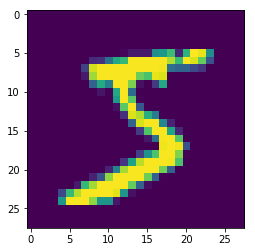

In [8]:
plt.imshow(x_train[0])

In [77]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    #print(X.shape,Y.shape)
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:]
    shuffled_Y = Y[permutation,:]#.reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [78]:
#let's normalize grayscale values
X_train=x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)/255
X_test=x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],1)/255
print(X_train.shape)

(60000, 28, 28, 1)


In [79]:
import sklearn
from sklearn.preprocessing import OneHotEncoder
onehot=OneHotEncoder(sparse=False)
Y_train=onehot.fit_transform(y_train.reshape(len(y_train),1))
Y_test=onehot.fit_transform(y_test.reshape(len(y_test),1))

/home/akshay/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/akshay/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto

In [80]:
def create_placeholders(n_H0,n_W0,n_C0,n_y):
    X=tf.placeholder(tf.float32,shape=[None,n_H0,n_W0,n_C0])
    Y = tf.placeholder(tf.float32,shape=([None,n_y]))
    
    return X,Y

In [81]:
def initialize_parameters():
    tf.set_random_seed(1)
    W1=tf.get_variableW1 = tf.get_variable('W1',[4,4,1,8],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable('W2',[2,2,8,16],initializer=tf.contrib.layers.xavier_initializer(seed=0))
    
    parameters={"W1":W1,
               "W2":W2}
    
    return parameters

In [82]:
def forward_prop(X,parameters):
    W1 = parameters['W1']
    W2 = parameters['W2']
    #print(X.shape,W1.shape)
    Z1 = tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding='SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1,ksize=[1,8,8,1],strides=[1,8,8,1],padding='SAME')
    Z2 = tf.nn.conv2d(P1,W2,strides=[1,1,1,1],padding='SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2,ksize=[1,4,4,1],strides=[1,4,4,1],padding='SAME')
    P2 = tf.contrib.layers.flatten(P2)
    Z3 = tf.contrib.layers.fully_connected(P2,10,activation_fn=None)
    
    return Z3

In [83]:
def compute_cost(Z3,Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3,labels=Y))
    return cost

In [88]:
def model (X_train,Y_train,X_test,Y_test,learning_rate=.0001, num_epochs=100,minibatch_size=500,print_cost=True):
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed=3
    #print(X_train.shape)
    (m, n_H0, n_W0,n_C0) = X_train.shape           
    n_y = Y_train.shape[1]                            
    costs = []
    
    X,Y=create_placeholders(n_H0, n_W0, n_C0, n_y)
    #print(n_C0)
    parameters=initialize_parameters()
    
    Z3=forward_prop(X,parameters)
    
    cost=compute_cost(Z3,Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            minibatch_cost=0
            num_minibatches=int(m/minibatch_size)
            seed=seed+1
            #print(X_train.shape)
            minibatches=random_mini_batches(X_train, Y_train,minibatch_size,seed)
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost=sess.run([optimizer,cost],feed_dict={X:minibatch_X,Y:minibatch_Y})
                
                minibatch_cost+=temp_cost/num_minibatches
                
            if print_cost==True and epoch%10==0:
                print("Cost after epoch %i:%f"%(epoch,minibatch_cost))
            if print_cost==True and epoch%1==0:
                costs.append(minibatch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

In [ ]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

Cost after epoch 0:2.411135
Cost after epoch 10:2.082402
